In [1243]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()

In [1244]:
def fn_Psi_spatial(x):
    x = (x>0).astype(int)
    return ''.join([str(y) for y in x.flatten()])

def extract(x, U):
    y = np.zeros((len(U), d))
    for i, u in enumerate(U):
        y[i: i+1] = x[u: u+1]
    return y

In [1245]:
random_graph = 'ER'
n = 10
p = 0.1
T = 10000
d = 3
tau_0 = 100

MAX_MU = 1000
MIN_STD = 40.0
MAX_STD = 50.0

In [1246]:
G = nx.erdos_renyi_graph(n, p)
A = np.array(nx.adjacency_matrix(G).todense()) + np.eye(n)

/tmp/ipykernel_1397170/2492515426.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(G).todense()) + np.eye(n)


In [1247]:
# shocks
E = np.zeros((T, n, d))
E[0] = np.array((np.random.rand(n*d) > 0.5).astype('int')).reshape((n,d))


In [1248]:
# create the arms
U = {}

for v in range(n):
    U[v] = np.where(A[v]==1)[0]
    
# create a dictionary of states
S = {}
for v in range(n):
    S[v] = {}

In [1249]:
class Gaussian:
    def __init__(self):
        self.mu = np.random.uniform(-MAX_MU, MAX_MU, size=(d,))
        self.std = np.random.uniform(MIN_STD, MAX_STD, size=(d,))
        
    def sample(self):
        return np.random.normal(self.mu, self.std)

In [1250]:
for t in tqdm(range(T-1)):
    for v in range(n):
        current_shock = extract(E[t], U[v])
        current_state = fn_Psi_spatial(current_shock)

        if current_state not in S[v].keys():
            S[v][current_state] = Gaussian()
        
        # noise_seasonal = f(t)
        E[t+1][v: v+1] = S[v][current_state].sample()

100%|██████████| 999/999 [00:00<00:00, 8058.01it/s]


In [1251]:
X = np.zeros((T, n, d))
X[0] = E[0]
for t in tqdm(range(1,T)):
    X[t] = E[t] + X[t-1]

100%|██████████| 999/999 [00:00<00:00, 1235656.06it/s]


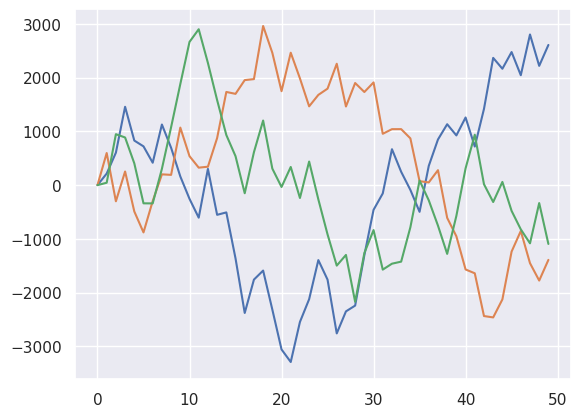

In [1252]:
for i in range(3):
    plt.plot(X[0:int(T/20),i,0])

In [1253]:
data_key = '04'
import pickle 
G = {'X': X, 'A': A}
with open(f"../dataset/synth_{data_key}.pkl", 'wb') as file:
    pickle.dump(G, file)

In [1254]:
import csv

np.savez("../dataset/synthetic/data_{data_key}", data=X)
with open('../dataset/synthetic/distance_{data_key}.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['from', 'to', 'cost'])  # Write the header

    for i in range(n):
        for j in range(n):
            if A[i][j] == 0:
                writer.writerow([i, j, 1000])
            if A[i][j] == 1:
                writer.writerow([i, j, 1])